/tmp/ipython-input-8-603739998.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2022-01-01", end="2024-01-01")[['Close']].copy()
[*********************100%***********************]  1 of 1 completed


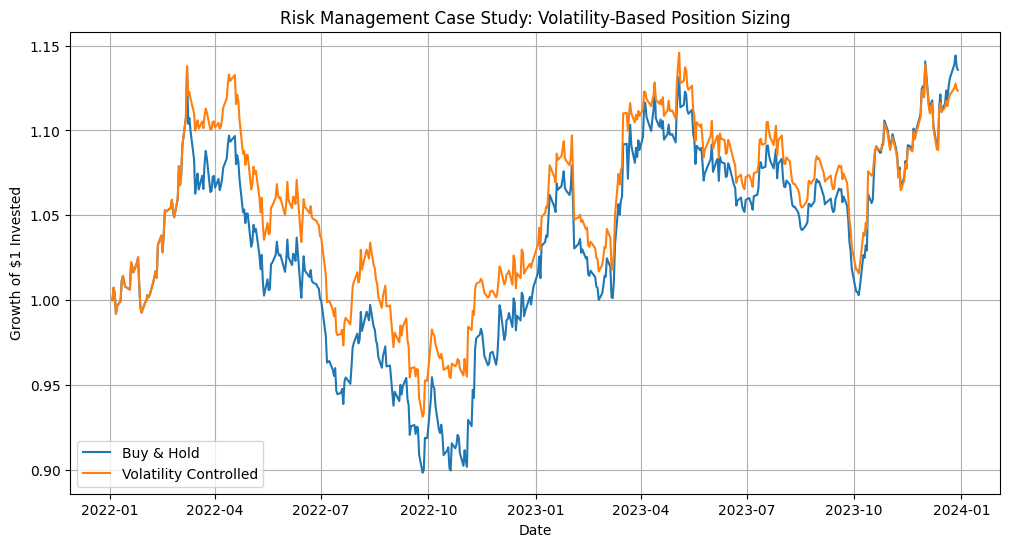

Max Drawdown (Strategy): 20.62%
Sharpe Ratio (Strategy): 0.52


In [8]:
# Install dependencies (Google Colab or first time use)
!pip install yfinance openpyxl --quiet

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download example data (Gold ETF; change symbol as needed)
symbol = "GLD"
df = yf.download(symbol, start="2022-01-01", end="2024-01-01")[['Close']].copy()

# Calculate historical volatility (rolling standard deviation)
df['Volatility'] = df['Close'].pct_change().rolling(20).std()  # 20-day rolling volatility

# Risk management rule: If volatility > threshold, reduce position to 50%, else 100%
vol_threshold = df['Volatility'].quantile(0.75)  # top 25% high volatility filter
df['PositionSize'] = df['Volatility'].apply(
    lambda x: 0.5 if x > vol_threshold else 1.0
)

# Calculate returns
df['Returns'] = df['Close'].pct_change().fillna(0)

# Strategy: always in the market, but with dynamic position sizing
df['Strategy'] = df['Returns'] * df['PositionSize'].shift(1, fill_value=1.0)

# Cumulative equity curves
df['Equity_Mkt'] = (1 + df['Returns']).cumprod()
df['Equity_Strategy'] = (1 + df['Strategy']).cumprod()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Equity_Mkt'], label="Buy & Hold")
plt.plot(df.index, df['Equity_Strategy'], label="Volatility Controlled")
plt.title("Risk Management Case Study: Volatility-Based Position Sizing")
plt.xlabel("Date")
plt.ylabel("Growth of $1 Invested")
plt.legend()
plt.grid()
plt.show()

# Key risk metrics
max_drawdown = (df['Equity_Strategy'].cummax() - df['Equity_Strategy']).max()
sharpe = df['Strategy'].mean() / df['Strategy'].std() * (252 ** 0.5)
print(f"Max Drawdown (Strategy): {max_drawdown:.2%}")
print(f"Sharpe Ratio (Strategy): {sharpe:.2f}")

# Save results to Excel
summary = df[['Close', 'Volatility', 'PositionSize', 'Returns', 'Strategy', 'Equity_Mkt', 'Equity_Strategy']]
summary.to_excel("RiskManagementCaseStudy_Volatility.xlsx")